In [1]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

### 14.2.1 Generate 100 random samples

In [2]:
def gen_random(n=100):
    means = [20, 5]
    covs = [[2, 0.8], [0.8, 0.5]]
    return pd.DataFrame(stats.multivariate_normal.rvs(means, covs, size=n), columns=['ut', 'uc'])

In [3]:
rand_data = gen_random()

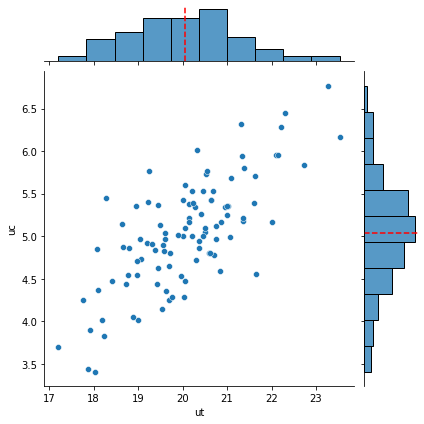

In [4]:
g = sns.jointplot(data=rand_data, x='ut', y='uc') 
g.ax_marg_x.axvline(rand_data.ut.mean(), color='r', linestyle='--')
g.ax_marg_y.axhline(rand_data.uc.mean(), color='r', linestyle='--')

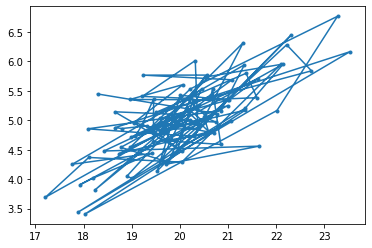

In [5]:
plt.plot(rand_data.ut, rand_data.uc, '.-')

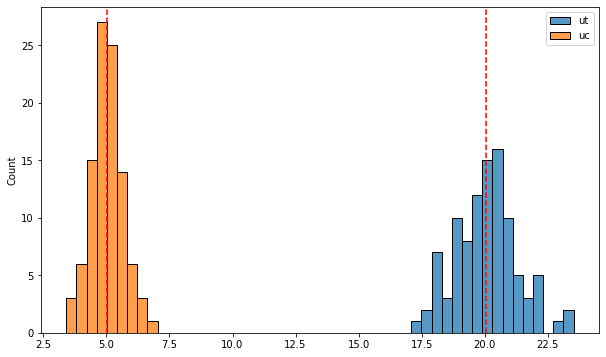

In [6]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(rand_data, bins=50, stat='count')
ax.axvline(rand_data.ut.mean(), color='r', linestyle='--')
ax.axvline(rand_data.uc.mean(), color='r', linestyle='--')

### 14.2.2 Code up a Random Walk Metropolis sampler

In [7]:
def propose_step(current):
    return stats.multivariate_normal.rvs(current)

In [8]:
def calc_ratio(current, proposed):
    p_current = stats.multivariate_normal.pdf(current, mean=[5,20], cov=[[2, 0.8], [0.8, 0.5]])
    p_proposed = stats.multivariate_normal.pdf(proposed, mean=[5,20], cov=[[2, 0.8], [0.8, 0.5]])
    return p_proposed/p_current

In [9]:
def get_next_value(current):
    proposed = propose_step(current)
    ratio = calc_ratio(current, proposed)
    u = stats.uniform.rvs()
    if ratio > u:
        return proposed
    return current    

In [10]:
def RWMetropolis(start, n):
    results = [start]
    for _ in range(n):
        results.append(get_next_value(results[-1]))
    return pd.DataFrame(results, columns=['ut', 'uc'])

In [11]:
rmw_data = RWMetropolis((5, 10), 100)

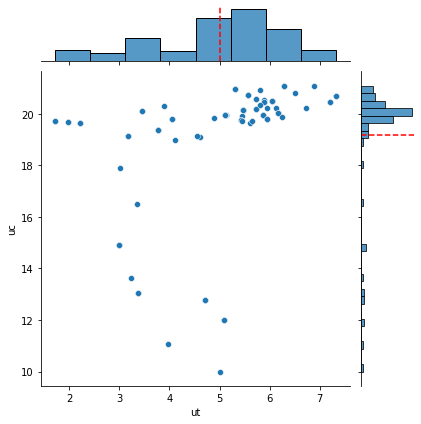

In [12]:
g = sns.jointplot(data=rmw_data, x='ut', y='uc') 
g.ax_marg_x.axvline(rmw_data.ut.mean(), color='r', linestyle='--')
g.ax_marg_y.axhline(rmw_data.uc.mean(), color='r', linestyle='--')

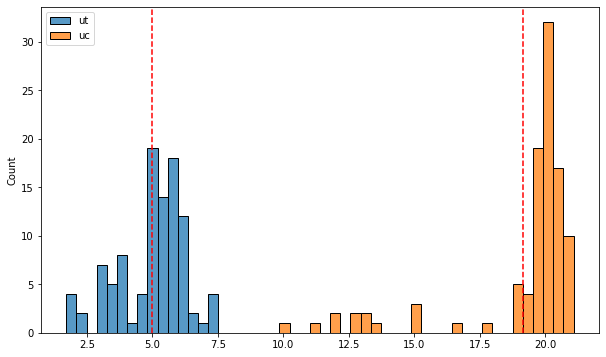

In [13]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(rmw_data, bins=50, stat='count')
ax.axvline(rmw_data.ut.mean(), color='r', linestyle='--')
ax.axvline(rmw_data.uc.mean(), color='r', linestyle='--')

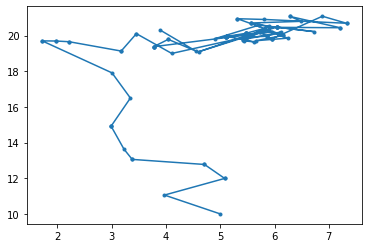

In [14]:
plt.plot(rmw_data.ut, rmw_data.uc, '.-')